In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

In [2]:
dataset_names = ['adult', 'compas', 'german']
model_names = ['HBFC', 'DT', 'NN', 'HGB']
lambdas = [0.7, 0.8, 0.9]

In [3]:
def generate_dict_info(dataset, model, lamb):
    dict_results = {}
    txt_files = glob.glob('outputs/{}_lamb{}*_{}*.txt'.format(model, lamb, dataset))
    fairness_rates, lamb_fairness_rates, accuracy_rates, lamb_accuracy_rates, consistency_rates, lamb_consistency_rates = [], [], [], [], [], []
    for _file in txt_files:
        with open (_file) as file:
            txt = file.readlines()
            for i in range(len(txt)):
                if txt[i] == 'FAIRNESS RATES: \n':
                    fairness_rates.append(txt[i+2])
                    lamb_fairness_rates.append(txt[i+5])
                if txt[i] == 'ACCURACY RATES:\n':
                    accuracy_rates.append(txt[i+2])
                    lamb_accuracy_rates.append(txt[i+5])
                if txt[i] == 'CONSISTENCY RATES:\n':
                    consistency_rates.append(txt[i+2])
                    lamb_consistency_rates.append(txt[i+5])        
        # OF: Original Fairness, LF: Lambda Fairness, OA: Original Accuracy, LA: Lambda Accuracy
        dict_results['OF'] = np.mean(list(map(float, fairness_rates)))
        dict_results['LF'] = np.mean(list(map(float, lamb_fairness_rates)))
        dict_results['OA'] = np.mean(list(map(float, accuracy_rates)))
        dict_results['LA'] = np.mean(list(map(float, lamb_accuracy_rates)))
        dict_results['OC'] = np.mean(list(map(float, consistency_rates)))
        dict_results['LC'] = np.mean(list(map(float, lamb_consistency_rates)))
    
    return dict_results

In [4]:
def getting_results(dataset, model_names):
    results = {}
    for lamb in lambdas:
        for model in model_names:
            results['{} {} {}'.format(lamb, dataset, model)] = generate_dict_info(dataset, model, lamb)

    return results

In [5]:
def generate_graphics(title, xlabel, ylabel, metric_values_list, original_value_list, metric, loc='lower right'):
    ind = np.arange(4) 
    width = 0.17

    for i, c in zip(range(4), ['#DA70D6', '#1E90FF', '#008176', '#871fd1']):
        globals()['bar'+str(i+1)] = plt.bar(ind+width*i, [np.mean(original_value_list[i])] + metric_values_list[i], width, color = c)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])  
    plt.xticks(ind+width, ['Orig. {}'.format(metric), 0.7, 0.8, 0.9])
    plt.legend((bar1, bar2, bar3, bar4), ('HBFC', 'Decision Tree', 'NN', 'HGB'), loc=loc, fontsize='small')#(1.02, 0.78))

    plt.savefig('analysis graphics/{}.png'.format(title), dpi=(3000))
    plt.show()

# German Credit Risk graphics

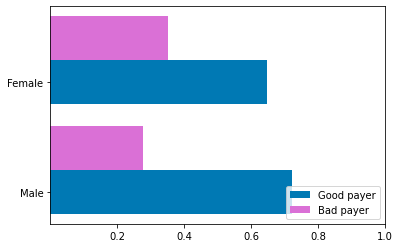

In [6]:
german = pd.read_csv('full data/german_data.csv')
protected_counts = dict(german['sex'].value_counts())
counts = dict(german[['sex', 'classification']].value_counts())
bars = [bar[0]+' '+bar[1] for bar in np.array(list(counts.keys()), dtype=str)]
counts = dict(zip(bars, counts.values()))

for prot in german['sex'].unique():
    for b in bars:
        if prot in b:
            counts[b] /= protected_counts[prot]

ind = np.arange(len(protected_counts)) 
width = 0.4

yes = list({k: v for k, v in counts.items() if k.endswith('Good')}.values())
no = list({k: v for k, v in counts.items() if k.endswith('Bad')}.values())

bar1 = plt.barh(ind, yes, width, color='#0079b4')
bar2 = plt.barh(ind+width, no, width, color='#DA70D6')

plt.yticks(np.arange(len(protected_counts)), list(protected_counts.keys()))
plt.xticks([0.2,0.4,0.6,0.8,1.0])
plt.legend((bar1, bar2), ('Good payer', 'Bad payer'), loc='lower right')
plt.savefig('analysis graphics/german_info_protected')
plt.show()

In [7]:
results = getting_results('german', model_names)
OFs = [[results['{} german {}'.format(lamb, model)]['OF'] for lamb in lambdas] for model in model_names]
OAs = [[results['{} german {}'.format(lamb, model)]['OA'] for lamb in lambdas] for model in model_names]
OCs = [[results['{} german {}'.format(lamb, model)]['OC'] for lamb in lambdas] for model in model_names]
LFs = [[results['{} german {}'.format(lamb, model)]['LF'] for lamb in lambdas] for model in model_names]
LAs = [[results['{} german {}'.format(lamb, model)]['LA'] for lamb in lambdas] for model in model_names]
LCs = [[results['{} german {}'.format(lamb, model)]['LC'] for lamb in lambdas] for model in model_names]

In [8]:
#print('{}\nDT 0.9 results:\n\n'.format('*'*50))
#print('Original AUC: {}\nLambda AUC: {}\nOriginal Consistency: {}\nLambda Consistency: {}\n\n{}'.format(OAs[0][2], LAs[0][2], OCs[0][2], LCs[0][2], '*'*50))
results

{'0.7 german HBFC': {'OF': 0.0,
  'LF': 0.7193333333333334,
  'OA': 0.5681265014885838,
  'LA': 0.5314633093411694,
  'OC': 0.7106666666666667,
  'LC': 0.6158666666666667},
 '0.7 german DT': {'OF': 0.30066666666666664,
  'LF': 0.7066666666666666,
  'OA': 0.6576465709086887,
  'LA': 0.64612375449878,
  'OC': 0.8922666666666664,
  'LC': 0.9074666666666666},
 '0.7 german NN': {'OF': 0.0,
  'LF': 0.7059999999999997,
  'OA': 0.6452050542714527,
  'LA': 0.5857125676645796,
  'OC': 0.7469333333333333,
  'LC': 0.8916000000000001},
 '0.7 german HGB': {'OF': 0.5326666666666665,
  'LF': 0.7586666666666666,
  'OA': 0.704780644230141,
  'LA': 0.691047002459199,
  'OC': 0.878,
  'LC': 0.8906666666666667},
 '0.8 german HBFC': {'OF': 0.0,
  'LF': 0.8093333333333335,
  'OA': 0.5675135170032974,
  'LA': 0.5240384589357097,
  'OC': 0.6974666666666666,
  'LC': 0.6415999999999998},
 '0.8 german DT': {'OF': 0.30066666666666664,
  'LF': 0.8033333333333336,
  'OA': 0.6576465709086887,
  'LA': 0.65011034641811

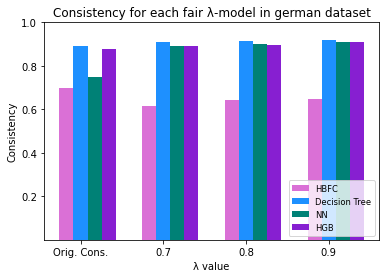

In [25]:
generate_graphics('Consistency for each fair λ-model in german dataset', 'λ value', 'Consistency', LCs, OCs, 'Cons.')

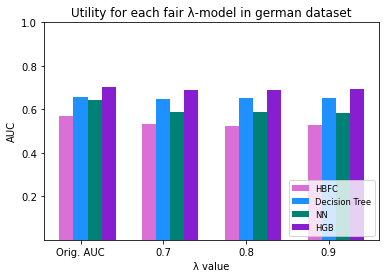

In [26]:
generate_graphics('Utility for each fair λ-model in german dataset', 'λ value', 'AUC', LAs, OAs, 'AUC')

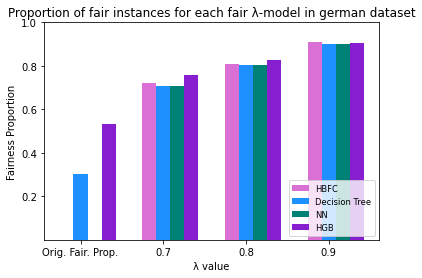

In [27]:
generate_graphics('Proportion of fair instances for each fair λ-model in german dataset', 'λ value', 'Fairness Proportion', LFs, OFs, 'Fair. Prop.')

# Adult Income dataset graphics

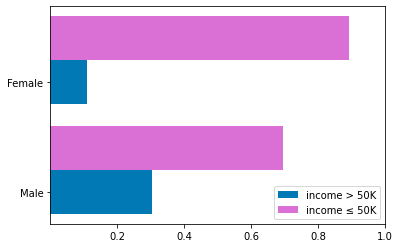

In [9]:
adult = pd.read_csv('full data/adult.csv')
protected_counts = dict(adult['gender'].value_counts())
counts = dict(adult[['gender', 'income']].value_counts())
bars = [bar[0]+' '+bar[1] for bar in np.array(list(counts.keys()), dtype=str)]
counts = dict(zip(bars, counts.values()))

for prot in adult['gender'].unique():
    for b in bars:
        if prot in b:
            counts[b] /= protected_counts[prot]

ind = np.arange(len(protected_counts)) 
width = 0.4

yes = list({k: v for k, v in counts.items() if k.endswith('>50K')}.values())
no = list({k: v for k, v in counts.items() if k.endswith('<=50K')}.values())

bar1 = plt.barh(ind, yes, width, color='#0079b4')
bar2 = plt.barh(ind+width, no, width, color='#DA70D6')

plt.yticks(np.arange(len(protected_counts)), list(protected_counts.keys()))
plt.xticks([0.2,0.4,0.6,0.8,1.0])
plt.legend((bar1, bar2), ('income > 50K', 'income ≤ 50K'), loc='lower right')
plt.savefig('analysis graphics/adult_info_protected')
plt.show()

In [10]:
results = getting_results('adult', model_names)
OFs = [[results['{} adult {}'.format(lamb, model)]['OF'] for lamb in lambdas] for model in model_names]
OAs = [[results['{} adult {}'.format(lamb, model)]['OA'] for lamb in lambdas] for model in model_names]
OCs = [[results['{} adult {}'.format(lamb, model)]['OC'] for lamb in lambdas] for model in model_names]
LFs = [[results['{} adult {}'.format(lamb, model)]['LF'] for lamb in lambdas] for model in model_names]
LAs = [[results['{} adult {}'.format(lamb, model)]['LA'] for lamb in lambdas] for model in model_names]
LCs = [[results['{} adult {}'.format(lamb, model)]['LC'] for lamb in lambdas] for model in model_names]

In [11]:
results

{'0.7 adult HBFC': {'OF': 0.002837200528202229,
  'LF': 0.7569331420344679,
  'OA': 0.6204773015254903,
  'LA': 0.5541150215701539,
  'OC': 0.8460408836632386,
  'LC': 0.9968746964643364},
 '0.7 adult DT': {'OF': 0.16918109781208937,
  'LF': 0.713099141475684,
  'OA': 0.7986971973845204,
  'LA': 0.7918131397452257,
  'OC': 0.9483387200012251,
  'LC': 0.9199231813385879},
 '0.7 adult NN': {'OF': 0.003546099290780143,
  'LF': 0.7138619251926275,
  'OA': 0.7088087856016467,
  'LA': 0.657116470584574,
  'OC': 0.887699615374327,
  'LC': 0.9409893181469239},
 '0.7 adult HGB': {'OF': 0.2064005352531351,
  'LF': 0.728498778721675,
  'OA': 0.794186831935279,
  'LA': 0.7586817504534291,
  'OC': 0.9251152360962148,
  'LC': 0.9103612067978427},
 '0.8 adult HBFC': {'OF': 0.006391246934540651,
  'LF': 0.8287824545068752,
  'OA': 0.6166178531817709,
  'LA': 0.5606875595342034,
  'OC': 0.8686692998383394,
  'LC': 0.9991397849462367},
 '0.8 adult DT': {'OF': 0.16918109781208937,
  'LF': 0.8115138020539

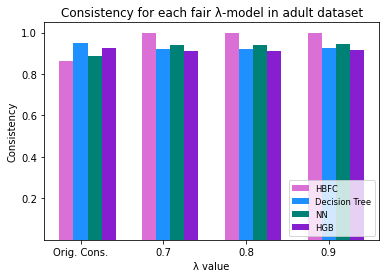

In [30]:
generate_graphics('Consistency for each fair λ-model in adult dataset', 'λ value', 'Consistency', LCs, OCs, 'Cons.')

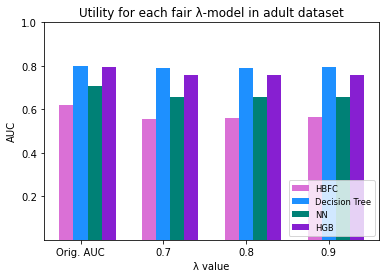

In [31]:
generate_graphics('Utility for each fair λ-model in adult dataset', 'λ value', 'AUC', LAs, OAs, 'AUC')

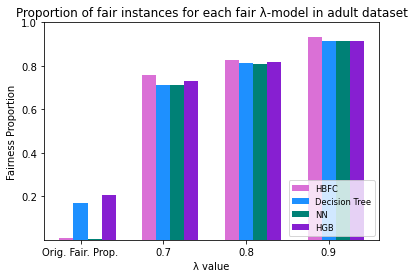

In [32]:
generate_graphics('Proportion of fair instances for each fair λ-model in adult dataset', 'λ value', 'Fairness Proportion', LFs, OFs, 'Fair. Prop.')

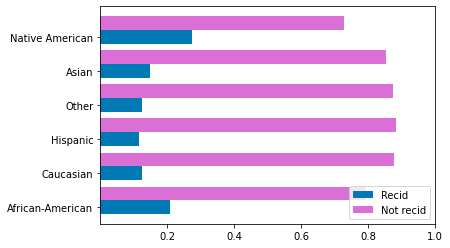

In [12]:
compas = pd.read_csv('full data/compas.csv')
protected_counts = dict(compas['race'].value_counts())
counts = dict(compas[['race', 'two_year_recid']].value_counts())
bars = [bar[0]+' '+bar[1] for bar in np.array(list(counts.keys()), dtype=str)]
counts = dict(zip(bars, counts.values()))

for prot in compas['race'].unique():
    for b in bars:
        if prot in b:
            counts[b] /= protected_counts[prot]

ind = np.arange(len(protected_counts)) 
width = 0.4

yes = list({k: v for k, v in counts.items() if k.endswith('Yes')}.values())
no = list({k: v for k, v in counts.items() if k.endswith('No')}.values())

bar1 = plt.barh(ind, yes, width, color='#0079b4')
bar2 = plt.barh(ind+width, no, width, color='#DA70D6')

plt.yticks(np.arange(len(protected_counts)), list(protected_counts.keys()))
plt.xticks([0.2,0.4,0.6,0.8,1.0])
plt.legend((bar1, bar2), ('Recid', 'Not recid'), loc='lower right')
plt.savefig('analysis graphics/compas_info_protected')
plt.show()

In [13]:
results = getting_results('compas', model_names)
OFs = [[results['{} compas {}'.format(lamb, model)]['OF'] for lamb in lambdas] for model in model_names]
OAs = [[results['{} compas {}'.format(lamb, model)]['OA'] for lamb in lambdas] for model in model_names]
OCs = [[results['{} compas {}'.format(lamb, model)]['OC'] for lamb in lambdas] for model in model_names]
LFs = [[results['{} compas {}'.format(lamb, model)]['LF'] for lamb in lambdas] for model in model_names]
LAs = [[results['{} compas {}'.format(lamb, model)]['LA'] for lamb in lambdas] for model in model_names]
LCs = [[results['{} compas {}'.format(lamb, model)]['LC'] for lamb in lambdas] for model in model_names]

In [14]:
results

{'0.7 compas HBFC': {'OF': 0.0,
  'LF': 0.7866666666666667,
  'OA': 0.934722983882075,
  'LA': 0.7229938918318146,
  'OC': 0.8406666666666666,
  'LC': 0.9968000000000001},
 '0.7 compas DT': {'OF': 0.0,
  'LF': 0.7046666666666667,
  'OA': 0.9911261336857944,
  'LA': 0.9770096170045668,
  'OC': 0.8408000000000001,
  'LC': 0.9665333333333332},
 '0.7 compas NN': {'OF': 0.0,
  'LF': 0.7033333333333331,
  'OA': 0.9924675782831621,
  'LA': 0.9909539126677188,
  'OC': 0.8404000000000001,
  'LC': 0.8728000000000001},
 '0.7 compas HGB': {'OF': 0.1913333333333333,
  'LF': 0.7119999999999999,
  'OA': 0.9974739597797139,
  'LA': 0.9826548513263245,
  'OC': 0.8401333333333334,
  'LC': 0.9182666666666666},
 '0.8 compas HBFC': {'OF': 0.0,
  'LF': 0.862,
  'OA': 0.9282033797750598,
  'LA': 0.704574703959611,
  'OC': 0.8509333333333333,
  'LC': 0.9984},
 '0.8 compas DT': {'OF': 0.0,
  'LF': 0.802666666666667,
  'OA': 0.9911261336857944,
  'LA': 0.9778387037520745,
  'OC': 0.8408000000000001,
  'LC': 0.9

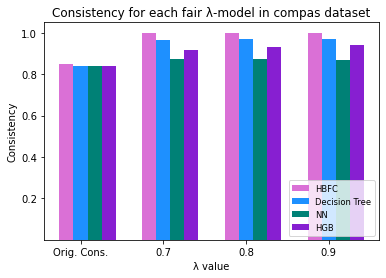

In [35]:
generate_graphics('Consistency for each fair λ-model in compas dataset', 'λ value', 'Consistency', LCs, OCs, 'Cons.')

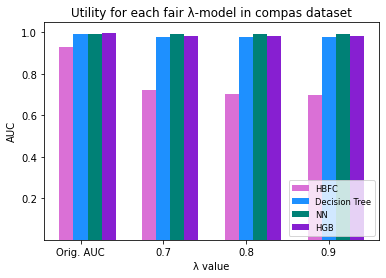

In [36]:
generate_graphics('Utility for each fair λ-model in compas dataset', 'λ value', 'AUC', LAs, OAs, 'AUC')

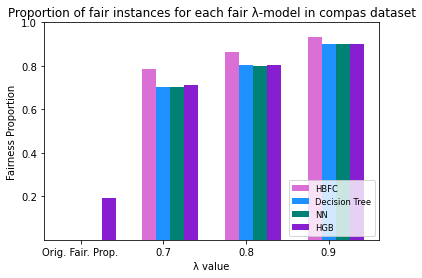

In [37]:
generate_graphics('Proportion of fair instances for each fair λ-model in compas dataset', 'λ value', 'Fairness Proportion', LFs, OFs, 'Fair. Prop.')